In [1]:
import csv
import pandas as pd
import nltk
from konlpy.tag import Okt
import matplotlib as npl
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.font_manager as fn
import numpy as np
font_name=fn.FontProperties(fname="C:/WIndows/Fonts/malgun.ttf").get_name()  #한글 꺠짐 패치
plt.rc("font",family=font_name)

npl.rcParams["axes.unicode_minus"]=False

# 1. 서울시 구별 CCTV 현황 분석

    -https://opengov.seoul.go.kr/
    -http://data.seoul.go.kr

In [3]:
cctv_seoul=pd.read_csv("data/seoul/cctv.csv")
cctv_seoul.head()

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
1,강동구,1010,379,99,155,377
2,강북구,831,369,120,138,204
3,강서구,911,388,258,184,81
4,관악구,2109,846,260,390,613


In [4]:
#인구수 자료 불러오기

pop_seoul = pd.read_excel("data/seoul/Report.xls",header=2,usecols="B,D,G,J,N")    #header 두번째 행을 제목으로 지정
pop_seoul.head()                                                                   # usercols 는 원하는 열데이터 정하기


,자치구,계,계.1,계.2,65세이상고령자
0,합계,10112070,9838892,273178,1382420
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752


## 전처리

In [5]:
#컬럼 이름을 변경

#CCTV 자료에서 기관명이라는 컬럼볌을 "구별"로 변경
cctv_seoul.rename(columns={cctv_seoul.columns[0] : "구별"},inplace=True)
cctv_seoul.head()

#인구수 데이터에서 컬럼양을 각각 구별, 인구수, 한국인, 외국인, 고령자로 변경
pop_seoul.rename(columns={pop_seoul.columns[0] : "구별",pop_seoul.columns[1] : "인구수",
                          pop_seoul.columns[2] : "한국인",pop_seoul.columns[3] : "외국인",
                         pop_seoul.columns[4] : "고령자"},inplace=True)

print(cctv_seoul.head())
print(pop_seoul.head())

    구별    소계  2013년도 이전  2014년  2015년  2016년
0  강남구  3238       1292    430    584    932
1  강동구  1010        379     99    155    377
2  강북구   831        369    120    138    204
3  강서구   911        388    258    184     81
4  관악구  2109        846    260    390    613
    구별       인구수      한국인     외국인      고령자
0   합계  10112070  9838892  273178  1382420
1  종로구    164348   154549    9799    26429
2   중구    135139   126082    9057    21655
3  용산구    245411   229909   15502    37238
4  성동구    314551   306532    8019    41752


## 3) 탐색적 데이터 분석

In [6]:
#어느 구가 가장 CCTV가 많이 설치 되었는가?
#------------------------------------------

#CCTV데이터에서 소계를 기준으로 정렬
cctv_seoul.sort_values(by=["소계"],ascending=False).head(5)

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,3238,1292,430,584,932
18,양천구,2482,1843,142,30,467
14,서초구,2297,1406,157,336,398
4,관악구,2109,846,260,390,613
21,은평구,2108,1138,224,278,468


In [7]:
#CCTV의 설치 증가율을 알아보기
#-----------------------------------

#CCTV설치 연도별 증가율을 구해서 '최근증가율' 컬럼을 새로 추가
cctv_seoul["최근증가율"]=((cctv_seoul[:]["2014년"]+cctv_seoul[:]["2015년"]+cctv_seoul[:]["2016년"])/cctv_seoul[:]["2013년도 이전"]).round(2)
cctv_seoul.sort_values(by=["최근증가율"],ascending=False).head(5)
cctv_seoul.sort_values(by=["최근증가율"],ascending=True).head(5)

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
18,양천구,2482,1843,142,30,467,0.35
13,서대문구,1254,844,50,68,292,0.49
20,용산구,2096,1368,218,112,398,0.53
5,광진구,878,573,78,53,174,0.53
14,서초구,2297,1406,157,336,398,0.63


In [8]:
#인구 대비 CCTV 설치 현황을 알아보자
#------------------------------------

#인구수 데이터에서 필요없는 행 삭제(서울시 전체 합계 삭제)  : del(대부분 컬럼), drop
pop_seoul.drop(0, inplace=True)
pop_seoul.head(5)


,구별,인구수,한국인,외국인,고령자
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752
5,광진구,371671,357149,14522,44470


In [9]:
pop_seoul["구별"].unique()

pop_seoul[pop_seoul["구별"].isnull()]
pop_seoul.drop(26).head(24)

,구별,인구수,한국인,외국인,고령자
1,종로구,164348,154549,9799,26429
2,중구,135139,126082,9057,21655
3,용산구,245411,229909,15502,37238
4,성동구,314551,306532,8019,41752
5,광진구,371671,357149,14522,44470
6,동대문구,364962,349308,15654,56284
7,중랑구,411552,406868,4684,59992
8,성북구,453902,442226,11676,66896
9,강북구,327511,323862,3649,57002
10,도봉구,345041,342861,2180,54293


In [10]:
#어느구가 가장 인구수가 많은가?

pop_seoul.sort_values(by=["인구수"],ascending=False)
print("전체인구수 : ",pop_seoul["인구수"].max()," ; ",pop_seoul["구별"][pop_seoul["인구수"].argmax()])
print("외국인 인구수 : ",pop_seoul["외국인"].max()," ; ",pop_seoul["구별"][pop_seoul["외국인"].argmax()])

전체인구수 :  671994  ;  송파구
외국인 인구수 :  34860  ;  영등포구


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """


In [11]:
#외국인 비율, 고령자 비율 컬럼을 추가해서 순위 확인

pop_seoul["외국인비율"]=pop_seoul["외국인"]/pop_seoul["인구수"]*100
pop_seoul["고령자비율"]=pop_seoul["고령자"]/pop_seoul["인구수"]*100

In [12]:
pop_seoul.sort_values(by=["외국인비율"],ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,403988,369128,34860,54704,8.628969,13.540996
18,금천구,253344,234238,19106,34640,7.541525,13.673109
17,구로구,440396,408369,32027,59838,7.272319,13.587317
2,중구,135139,126082,9057,21655,6.701988,16.024242
3,용산구,245411,229909,15502,37238,6.316750,15.173729
1,종로구,164348,154549,9799,26429,5.962348,16.081121
6,동대문구,364962,349308,15654,56284,4.289214,15.421880
5,광진구,371671,357149,14522,44470,3.907219,11.964883
13,서대문구,324871,312311,12560,49645,3.866150,15.281450
21,관악구,522292,504445,17847,70807,3.417054,13.556976


In [13]:
#인구 대비 CCTV 설치 현환을 알아보자
#------------------------------------

#CCTV 데이터와 인구수 데이터를 합치고 분석하기
data_result=pd.merge(cctv_seoul,pop_seoul,on="구별")
data_result.head()



,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,1292,430,584,932,1.51,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,379,99,155,377,1.66,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,369,120,138,204,1.25,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,388,258,184,81,1.35,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,846,260,390,613,1.49,522292,504445,17847,70807,3.417054,13.556976


In [14]:
#필요없는 컬럼 정리(제거) : 2013년도 이전, 2014,2015,2016 제거

del data_result["2013년도 이전"]
del data_result["2014년"]
del data_result["2015년"]
del data_result["2016년"]
data_result.head()

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,3238,1.51,557865,552976,4889,65859,0.876377,11.805544
1,강동구,1010,1.66,438225,434027,4198,56983,0.957955,13.003138
2,강북구,831,1.25,327511,323862,3649,57002,1.114161,17.404606
3,강서구,911,1.35,608361,601696,6665,77381,1.095567,12.719586
4,관악구,2109,1.49,522292,504445,17847,70807,3.417054,13.556976


In [15]:
#"구별" 컬럼을 인덱스로 설정

data_result.set_index("구별", inplace=True)
data_result.head()
data_result.set

AttributeError: 'DataFrame' object has no attribute 'set'

In [16]:
# CCTV의 갯수(소계)와 인구 데이터 중 어느 변수와 관계가 있는지를 확인
# 상관계수 : -1 ~ 1 numpy.corrcoef()
print(np.corrcoef(data_result["고령자비율"],data_result["소계"]))
print(np.corrcoef(data_result["외국인비율"],data_result["소계"]))
print(np.corrcoef(data_result["인구수"],data_result["소계"]))

[[ 1.         -0.26783452]
 [-0.26783452  1.        ]]
[[ 1.         -0.04656978]
 [-0.04656978  1.        ]]
[[1.         0.23037183]
 [0.23037183 1.        ]]


## 시각화

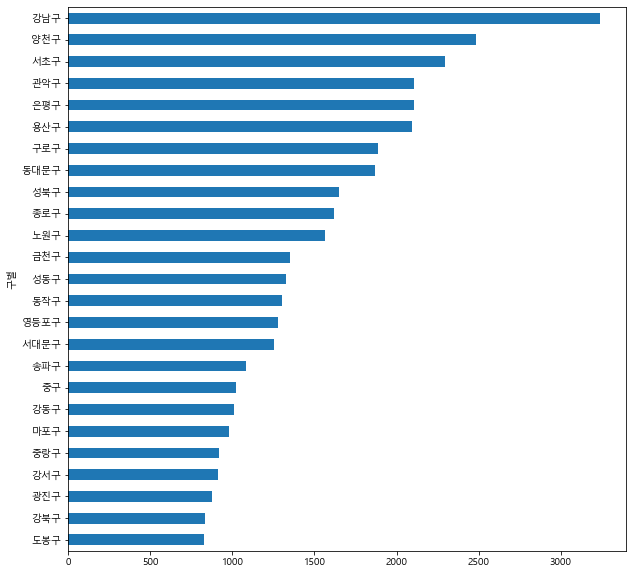

In [17]:
#CCTV가 많이 설치된 구별로 그래프 그리기
data_result["소계"].sort_values().plot(kind="barh",figsize=(10,10))

In [31]:
#CCTV비율 컬럼 추가(소계/인구수*100)
data_result["cctv비율"]= data_result["소계"]/data_result["인구수"]*100
data_result.head()

df_sort=data_result.sort_values(by=["오차"],ascending=False)
df_sort.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,3238,1.51,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
양천구,2482,0.35,473087,469221,3866,56070,0.817186,11.851943,0.524639,890.918761
강서구,911,1.35,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
용산구,2096,0.53,245411,229909,15502,37238,6.316750,15.173729,0.854077,756.346747
서초구,2297,0.63,445164,440954,4210,54055,0.945719,12.142716,0.515990,736.754790


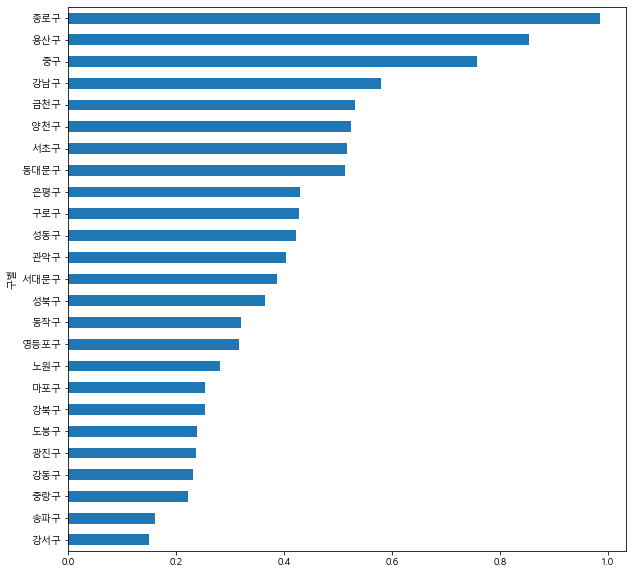

In [32]:
data_result["cctv비율"].sort_values().plot(kind="barh",figsize=(10,10))

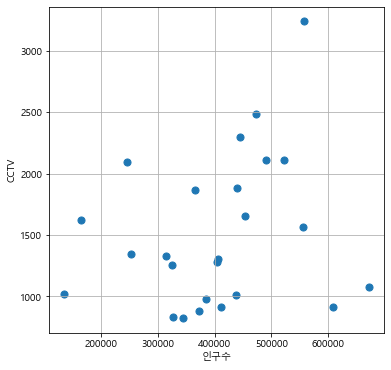

In [33]:
# CCTV의 설치대수와 인구수의 관계를 산포도로 확인

plt.figure(figsize=(6, 6))
plt.scatter(data_result["인구수"],data_result["소계"],s=50)
plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()

In [34]:
# 최소제곱법 numpy.poly1d
a=np.poly1d([1,2])
print(a)

b=np.poly1d([1,2,3])
print(b)

 
1 x + 2
   2
1 x + 2 x + 3


In [35]:
#회귀선 작성(y = ax + b)
fp1=np.polyfit(data_result["인구수"],data_result["소계"],1)
print(fp1) #순서대로 기울기, 절편

f1=np.poly1d(fp1)
print(f1)

fx = np.linspace(100000, 700000, 100)

[1.10432363e-03 1.06864009e+03]
 
0.001104 x + 1069


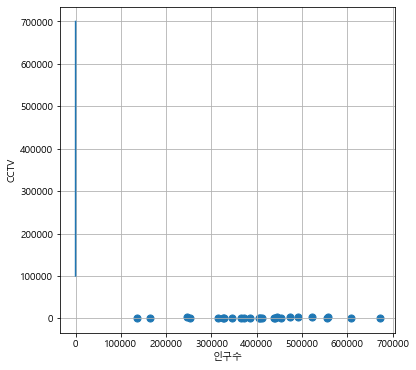

In [36]:

plt.figure(figsize=(6, 6))
plt.scatter(data_result["인구수"],data_result["소계"],s=50)
plt.plot(fx)
plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()

In [37]:
#각 데이터의 오차를 구하서 구 이름을 출력
data_result["오차"]=np.abs(data_result["소계"]-f1(data_result["인구수"]))
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,cctv비율,오차
구별,,,,,,,,,,
강남구,3238,1.51,557865,552976,4889,65859,0.876377,11.805544,0.580427,1553.296412
강동구,1010,1.66,438225,434027,4198,56983,0.957955,13.003138,0.230475,542.582309
강북구,831,1.25,327511,323862,3649,57002,1.114161,17.404606,0.253732,599.318223
강서구,911,1.35,608361,601696,6665,77381,1.095567,12.719586,0.149747,829.467513
관악구,2109,1.49,522292,504445,17847,70807,3.417054,13.556976,0.403797,463.580517


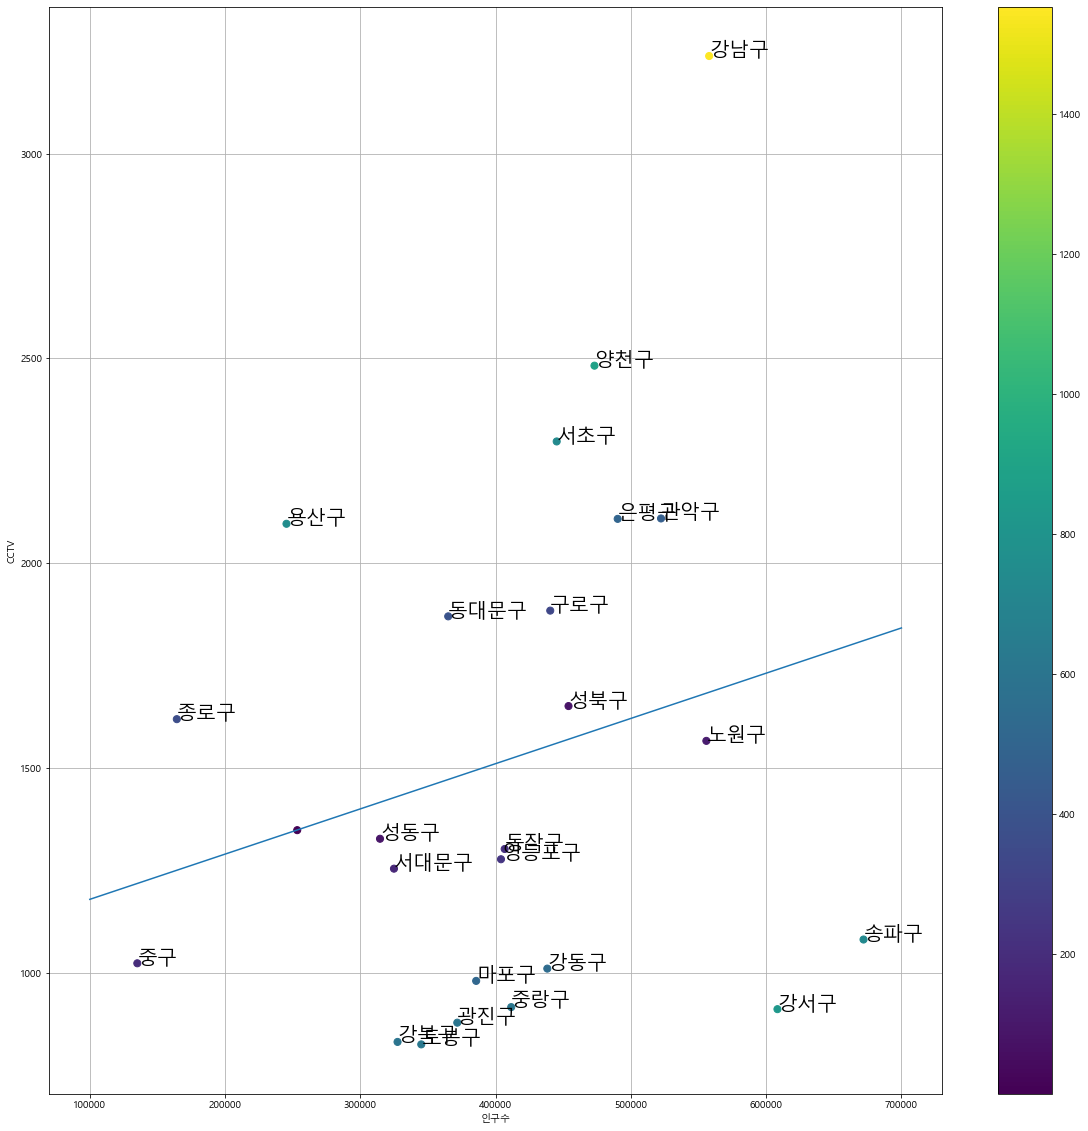

In [38]:
plt.figure(figsize=(20, 20))
plt.scatter(data_result["인구수"],data_result["소계"],s=50,c=data_result["오차"])
plt.plot(fx,f1(fx),linestyle="-")
plt.xlabel("인구수")
plt.ylabel("CCTV")
plt.grid()
plt.colorbar()

for n in range(24):
    plt.text(df_sort["인구수"][n],df_sort["소계"][n],df_sort.index[n],fontsize=20)

In [26]:
# 최종 결과물을 저장
df_sort.to_csv("data/seoul/cctv_result.csv",sep=",",encoding="utf-8")

NameError: name 'df_sort' is not defined